In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,dataset
from torchvision import models
from torchinfo import summary
import wandb
import os

In [1]:
import sys
!"{sys.executable}" -m pip install wandb

   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/22.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/22.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/22.3 MB ? eta -:--:--
    --------------------------------------- 0.5/22.3 MB 578.7 kB/s eta 0:00:38
    --------------------------------------- 0.5/22.3 MB 578.7 kB/s eta 0:00:38
    --------------------------------------- 0.5/22.3 MB 578.7 kB/s eta 0:00:38
    --------------------------------------- 0.5/22.3 MB 578.7 kB/s eta 0:00:38
   - -------------------------------------- 1.0/22.3 MB 578.7 kB/s eta 0:00:37
   - -------------------------------------- 1.0/22.3 MB 578.7 kB/s eta 0:00:37
   -- ------------------------------------- 1.3/22.3 MB 599.2 kB/s eta 0:00:36
   -- ---------------------


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Initialize wandb

wandb.init(project="Inception-flowers", config={
    "epochs": 50,
    "batch_size": 16,
    "learning_rate": 0.001,
    "architecture": "InceptionV1",
    "pretrained": True,
    "input_size": 224
})

# Shortcut to config values
config = wandb.config 


"""
While training models, you usually ask:
Which run gave the best accuracy?
What learning rate did I use that time?
Why did this model suddenly diverge?
Which hyperparameters actually mattered?
wandb answers all of this automatically.
"""

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: After creating your account, create a new API key and store it securely.
wandb: Paste your API key and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Lenovo\_netrc
wandb: Currently logged in as: yash-ingle002 (yash-ingle002-sardar-vallabhbhai-national-institute-of-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


# Transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Dataset path (YOUR CURRENT LOCATION)

data_dir = r"C:\Users\Lenovo\OneDrive\Desktop\deep Learning\Dataset\flowers"

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir)


# Train / Validation Split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

# Assign transforms AFTER split (important!)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


# DataLoaders

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False
)


In [6]:
# Load Pretrained Model
from torchvision.models import GoogLeNet_Weights


# Load pretrained GoogLeNet (Inception v1)
model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)

# Replace the final FC layer to match 5 flower classes
model.fc = nn.Linear(model.fc.in_features, 5)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final classification layer
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Watch the model's weights and gradients
wandb.watch(model, log="all", log_freq=10)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [03:09<00:00, 275kB/s]


In [7]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        running_loss = 0.0

        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 30)

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            batch_correct = (preds == labels).sum().item()
            train_correct += batch_correct
            train_total += labels.size(0)

            # Print every 10 batches
            if (i + 1) % 10 == 0:
                batch_acc = batch_correct / labels.size(0)
                print(f"[Batch {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}")

        train_acc = train_correct / train_total
        wandb.log({"epoch": epoch + 1, "train_loss": running_loss, "train_accuracy": train_acc})
        print(f"Epoch {epoch+1} Summary - Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        wandb.log({"epoch": epoch + 1, "val_accuracy": val_acc})
        print(f"Validation Accuracy: {val_acc:.4f}")


In [9]:
# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=config.epochs)


Epoch 1/50
------------------------------
[Batch 10/216] Loss: 1.5227, Batch Acc: 0.5000
[Batch 20/216] Loss: 1.2978, Batch Acc: 0.5625
[Batch 30/216] Loss: 1.1709, Batch Acc: 0.6875
[Batch 40/216] Loss: 1.2298, Batch Acc: 0.6250
[Batch 50/216] Loss: 1.0078, Batch Acc: 0.6875
[Batch 60/216] Loss: 1.2474, Batch Acc: 0.5625
[Batch 70/216] Loss: 1.3552, Batch Acc: 0.5000
[Batch 80/216] Loss: 0.7192, Batch Acc: 0.6875
[Batch 90/216] Loss: 0.9694, Batch Acc: 0.6250
[Batch 100/216] Loss: 0.8329, Batch Acc: 0.7500
[Batch 110/216] Loss: 0.6690, Batch Acc: 0.8125
[Batch 120/216] Loss: 0.7560, Batch Acc: 0.8125
[Batch 130/216] Loss: 0.6998, Batch Acc: 0.7500
[Batch 140/216] Loss: 0.7837, Batch Acc: 0.6250
[Batch 150/216] Loss: 0.7832, Batch Acc: 0.6875
[Batch 160/216] Loss: 0.7624, Batch Acc: 0.7500
[Batch 170/216] Loss: 0.5392, Batch Acc: 0.9375
[Batch 180/216] Loss: 0.4883, Batch Acc: 0.9375
[Batch 190/216] Loss: 0.4590, Batch Acc: 0.8750
[Batch 200/216] Loss: 0.6004, Batch Acc: 0.7500
[Batch

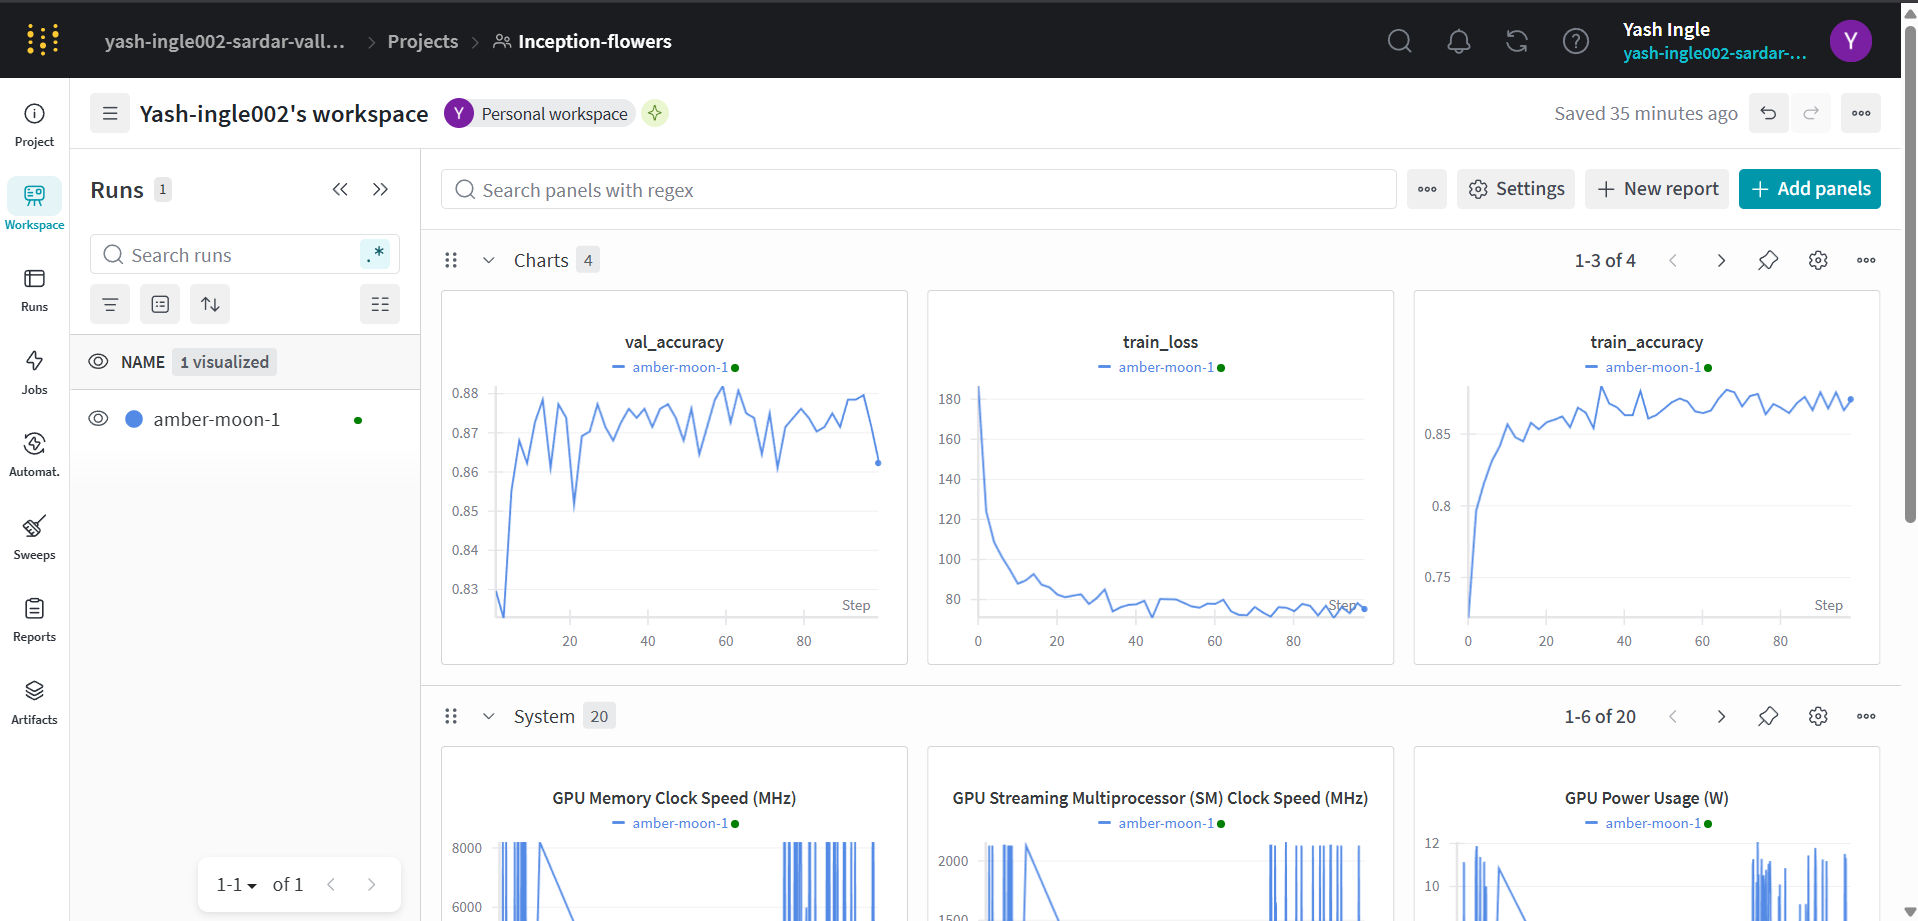